## Cell 1: Import Required Libraries

In [ ]:
import os
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

print('✅ All libraries imported successfully')

## Cell 2: Set Up Paths and Parameters

In [ ]:
# ==========================
# Paths
# ==========================
base_dir = "C:/Users/Administrator/Desktop/project/archive"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "test")
saved_model_dir = "C:/Users/Administrator/Desktop/project/saved_model/plant_disease_mobilenet"

# Create folder if not exists
os.makedirs(saved_model_dir, exist_ok=True)

print(f"Train directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Model save directory: {saved_model_dir}")
print("✅ Paths configured successfully")

## Cell 3: Define Training Parameters

In [ ]:
# ==========================
# Parameters
# ==========================
# CHOOSE YOUR CONFIGURATION:
# Option 1: NUM_CLASSES = 4  (miner, nodisease, phoma, rust) - SIMPLER, NO EXTRA IMAGES NEEDED
# Option 2: NUM_CLASSES = 5  (above + other) - WORKS WITH EMPTY "other" FOLDER

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_INITIAL = 50
EPOCHS_FINETUNE = 10
NUM_CLASSES = 5  # ← SET TO 5 SINCE "other" FOLDER EXISTS (even if empty)

print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Initial Training Epochs: {EPOCHS_INITIAL}")
print(f"Fine-tuning Epochs: {EPOCHS_FINETUNE}")
print(f"Number of Classes: {NUM_CLASSES}")
if NUM_CLASSES == 4:
    print("Classes: Coffee_cercospora_leaf_spot, Coffee_healthy, Coffee_red_spider_mite, Coffee_rust")
else:
    print("Classes: Coffee_cercospora_leaf_spot, Coffee_healthy, Coffee_red_spider_mite, Coffee_rust, other (empty folder)")
print("✅ Parameters configured successfully")

## Cell 4: Create Data Generators with Augmentation

In [ ]:
# ==========================
# Data Generators with Augmentation
# ==========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Class mapping: {train_generator.class_indices}")
print("✅ Data generators created successfully")

## Cell 4.5: Create 'Other' Class Directories for Non-Coffee Images

In [ ]:
# ==========================
# Verify Class Configuration
# ==========================
print("\n" + "="*60)
print("CLASS CONFIGURATION CHECK")
print("="*60)

import os

# Get actual directories
train_classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
test_classes = [d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))]

print(f"\nAvailable training classes: {sorted(train_classes)}")
print(f"Available validation classes: {sorted(test_classes)}")

# Check if "other" class has images
other_train_path = os.path.join(train_dir, "other")
other_test_path = os.path.join(val_dir, "other")

if os.path.exists(other_train_path):
    other_train_images = len([f for f in os.listdir(other_train_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
else:
    other_train_images = 0

if os.path.exists(other_test_path):
    other_test_images = len([f for f in os.listdir(other_test_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
else:
    other_test_images = 0

print(f"\n'Other' class images in training: {other_train_images}")
print(f"'Other' class images in validation: {other_test_images}")

if NUM_CLASSES == 4 and ("other" in train_classes or "other" in test_classes):
    print("\n⚠️  Using 4-class mode. 'Other' class exists but will be ignored.")
elif NUM_CLASSES == 5 and other_train_images == 0:
    print("\n⚠️  Using 5-class mode but 'other' class has no images!")
    print("    Recommendation: Either add images to 'train/other/' and 'test/other/'")
    print("                 OR change NUM_CLASSES to 4")
elif NUM_CLASSES == 5 and other_train_images > 0:
    print("\n✅ 5-class mode: 'other' class configured with images")
else:
    print("\n✅ Configuration looks good!")

print("="*60 + "\n")

## Cell 5: Define Training Callbacks

In [ ]:
# ==========================
# Callbacks
# ==========================
checkpoint_path = os.path.join(saved_model_dir, "best_model.h5")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

print("Callbacks configured:")
print("  - EarlyStopping: patience=5")
print("  - ModelCheckpoint: saves best model to", checkpoint_path)
print("  - ReduceLROnPlateau: reduces learning rate on validation loss plateau")
print("✅ Callbacks configured successfully")

## Cell 6: Build MobileNetV2 Model

In [ ]:
# ==========================
# Build MobileNetV2 Model
# ==========================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False  # freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Model Architecture:")
model.summary()
print("\n✅ Model built and compiled successfully")

## Cell 7: Initial Training (Base Frozen)

In [55]:
# ==========================
# Initial Training
# ==========================
print("=" * 60)
print("STARTING INITIAL TRAINING (Base Model Frozen)")
print("=" * 60)

history_initial = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS_INITIAL,
    callbacks=callbacks
)

print("\n✅ Initial training completed!")

Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7927 - loss: 0.5670
Epoch 1: val_loss improved from None to 0.08816, saving model to C:/Users/Administrator/Desktop/project/saved_model/plant_disease_mobilenet\best_model.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.8578 - loss: 0.3631 - val_accuracy: 0.9628 - val_loss: 0.0882 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.9076 - loss: 0.2232
Epoch 2: val_loss improved from 0.08816 to 0.05963, saving model to C:/Users/Administrator/Desktop/project/saved_model/plant_disease_mobilenet\best_model.h5

Epoch 2: val_loss improved from 0.08816 to 0.05963, saving model to C:/Users/Administrator/Desktop/project/saved_model/plant_disease_mobilenet\best_model.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9145 - loss: 0.2152 - val_accuracy: 0.9792 - val_loss: 0.0596 - learning_rate: 0.0010
Epoch 3/50
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.9398 - loss: 0.1659
Epoch 3: val_loss improved from 0.05963 to 0.04764, saving model to C:/Users/Administrator/Desktop/project/saved_model/plant_disease_mobilenet\best_model.h5

Epoch 3: val_loss improved from 0.05963 to 0.04764, saving model to C:/Users/Administrator/Desktop/project/saved_model/plant_disease_mobilenet\best_model.h5


119/119 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.9372 - loss: 0.1741 - val_accuracy: 0.9833 - val_loss: 0.0476 - learning_rate: 0.0010
Epoch 4/50
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.9442 - loss: 0.1526
Epoch 4: val_loss did not improve from 0.04764
119/119 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9467 - loss: 0.1480 - val_accuracy: 0.9785 - val_loss: 0.0532 - learning_rate: 0.0010
Epoch 5/50

Epoch 4: val_loss did not improve from 0.04764
119/119 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.9467 - loss: 0.1480 - val_accuracy: 0.9785 - val_loss: 0.0532 - learning_rate: 0.0010
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.9440 - loss: 0.1427
Epoch 5: val_loss improved from 0.04764 to 0.03899, saving model to C:/Users/Administrator/Desktop/project/saved_model/plant_disease_mobilenet\best_model.h5

Epoch 5: val_loss improved from 0.04764 to 0.03899, saving model to C:/Users/Administrator/Desktop/project/saved_model/plan

119/119 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.9467 - loss: 0.1421 - val_accuracy: 0.9877 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 6/50
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.9512 - loss: 0.1385
Epoch 6: val_loss did not improve from 0.03899
119/119 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9562 - loss: 0.1228 - val_accuracy: 0.9850 - val_loss: 0.0428 - learning_rate: 0.0010
Epoch 7/50

Epoch 6: val_loss did not improve from 0.03899
119/119 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9562 - loss: 0.1228 - val_accuracy: 0.9850 - val_loss: 0.0428 - learning_rate: 0.0010
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 875ms/step - accuracy: 0.9573 - loss: 0.1317
Epoch 7: val_loss improved from 0.03899 to 0.03898, saving model to C:/Users/Administrator/Desktop/project/saved_model/plant_disease_mobilenet\best_model.h5

Epoch 7: val_loss improved from 0.03899 to 0.03898, saving model to C:/Users/Administrator/Desktop/project/saved_model/plan

119/119 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9567 - loss: 0.1277 - val_accuracy: 0.9870 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 8/50
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 914ms/step - accuracy: 0.9638 - loss: 0.1022
Epoch 8: val_loss did not improve from 0.03898

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
119/119 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9583 - loss: 0.1123 - val_accuracy: 0.9809 - val_loss: 0.0471 - learning_rate: 0.0010
Epoch 9/50

Epoch 8: val_loss did not improve from 0.03898

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
119/119 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9583 - loss: 0.1123 - val_accuracy: 0.9809 - val_loss: 0.0471 - learning_rate: 0.0010
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.9535 - loss: 0.1087
Epoch 9: val_loss improved from 0.03898 to 0.03496, saving model to C:/Users/Administrator/Desktop/project/saved_model/plant_

119/119 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9607 - loss: 0.1003 - val_accuracy: 0.9887 - val_loss: 0.0350 - learning_rate: 2.0000e-04
Epoch 10/50
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.9689 - loss: 0.0899
Epoch 10: val_loss did not improve from 0.03496
119/119 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9710 - loss: 0.0878 - val_accuracy: 0.9870 - val_loss: 0.0384 - learning_rate: 2.0000e-04
Epoch 11/50

Epoch 10: val_loss did not improve from 0.03496
119/119 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9710 - loss: 0.0878 - val_accuracy: 0.9870 - val_loss: 0.0384 - learning_rate: 2.0000e-04
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.9679 - loss: 0.0916
Epoch 11: val_loss did not improve from 0.03496
119/119 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9705 - loss: 0.0847 - val_accuracy: 0.9887 - val_loss: 0.0365 - learning_rate: 2.0000e-04
Epoch 12/50

Epoch 11: val_loss did not improve from 0.03496
119/119 

## Cell 8: Define Visualization Function for Initial Results

In [56]:
def plot_initial_results(history):
    """Plot comprehensive training results before fine-tuning"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Initial Training Results (Base Model Frozen)', fontsize=16, fontweight='bold')
    
    epochs_range = range(1, len(history.history['accuracy']) + 1)
    
    # Accuracy
    axes[0, 0].plot(epochs_range, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(epochs_range, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Accuracy Over Epochs')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(epochs_range, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 1].plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Loss Over Epochs')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    metrics_text = f"""
    Final Training Accuracy: {final_train_acc:.4f}
    Final Validation Accuracy: {final_val_acc:.4f}
    Final Training Loss: {final_train_loss:.4f}
    Final Validation Loss: {final_val_loss:.4f}
    
    Accuracy Gap (Val - Train): {final_val_acc - final_train_acc:.4f}
    Loss Gap (Val - Train): {final_val_loss - final_train_loss:.4f}
    """
    
    axes[1, 0].text(0.1, 0.5, metrics_text, fontsize=11, verticalalignment='center',
                    family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1, 0].axis('off')
    
    # Best epoch marker
    best_val_acc_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_loss_epoch = np.argmin(history.history['val_loss']) + 1
    
    info_text = f"""
    Best Validation Accuracy: {max(history.history['val_accuracy']):.4f} (Epoch {best_val_acc_epoch})
    Best Validation Loss: {min(history.history['val_loss']):.4f} (Epoch {best_val_loss_epoch})
    Total Epochs Trained: {len(history.history['accuracy'])}
    """
    
    axes[1, 1].text(0.1, 0.5, info_text, fontsize=11, verticalalignment='center',
                    family='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✅ Visualization function defined")

✅ Visualization function defined


## Cell 9: Visualize Initial Training Results


VISUALIZING INITIAL TRAINING RESULTS



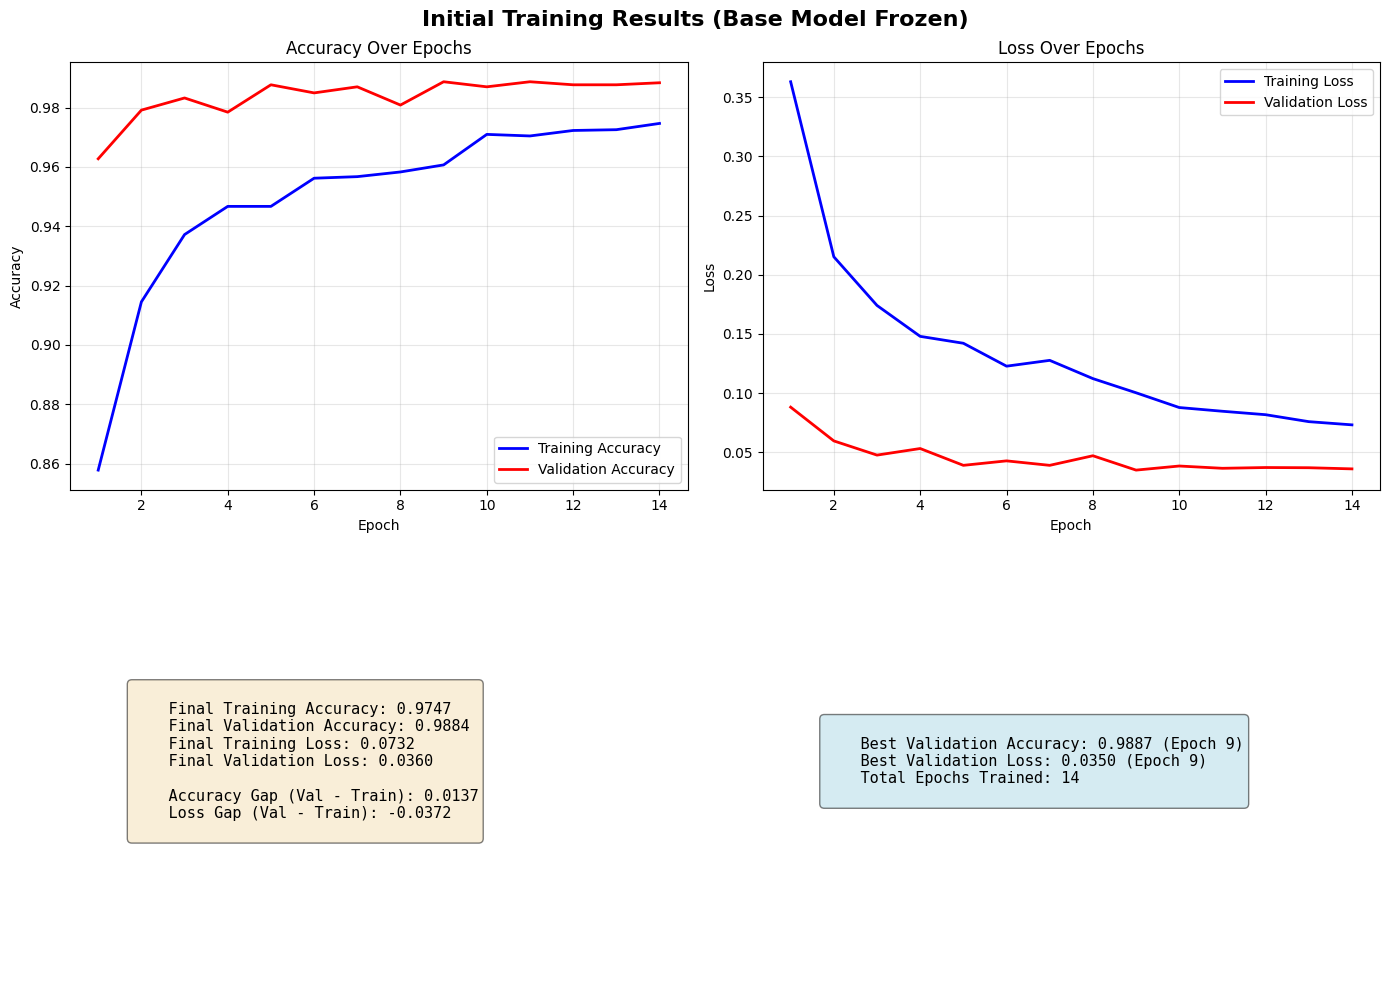


✅ Initial training visualization complete!
📊 Review the plots above to assess model performance before fine-tuning


In [57]:
# ==========================
# VISUALIZE INITIAL TRAINING RESULTS
# ==========================
print("\n" + "="*60)
print("VISUALIZING INITIAL TRAINING RESULTS")
print("="*60 + "\n")

plot_initial_results(history_initial)

print("\n✅ Initial training visualization complete!")
print("📊 Review the plots above to assess model performance before fine-tuning")

## Cell 10: Fine-Tuning Setup

In [58]:
# ==========================
# Fine-Tuning
# ==========================
print("\n" + "="*60)
print("PREPARING FOR FINE-TUNING")
print("="*60)

base_model.trainable = True
for layer in base_model.layers[:-50]:  # freeze all but last 50 layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("✅ Fine-tuning setup complete")
print(f"   - Unfroze last 50 layers of base model")
print(f"   - Learning rate: 1e-5")


PREPARING FOR FINE-TUNING
✅ Fine-tuning setup complete
   - Unfroze last 50 layers of base model
   - Learning rate: 1e-5


## Cell 11: Fine-Tuning Training

In [59]:
# ==========================
# Fine-Tuning
# ==========================
print("=" * 60)
print("STARTING FINE-TUNING TRAINING")
print("=" * 60)

history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS_FINETUNE,
    callbacks=callbacks
)

print("\n✅ Fine-tuning training completed!")

STARTING FINE-TUNING TRAINING
Epoch 1/10
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8789 - loss: 0.5070
Epoch 1: val_loss did not improve from 0.03496
119/119 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.9201 - loss: 0.2766 - val_accuracy: 0.9693 - val_loss: 0.0916 - learning_rate: 1.0000e-05
Epoch 2/10

Epoch 1: val_loss did not improve from 0.03496
119/119 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.9201 - loss: 0.2766 - val_accuracy: 0.9693 - val_loss: 0.0916 - learning_rate: 1.0000e-05
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9587 - loss: 0.1149
Epoch 2: val_loss did not improve from 0.03496
119/119 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9549 - loss: 0.1225 - val_accuracy: 0.9764 - val_loss: 0.0727 - learning_rate: 1.0000e-05
Epoch 3/10

Epoch 2: val_loss did not improve from 0.03496
119/119 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9549 - loss: 0.1225 - val_accuracy: 0.9764 - val_loss: 0.0727 - learning_rate: 1.00

## Cell 12: Save Models and Labels

## Cell 13: Convert to TFLite

In [60]:
# ==========================
# Convert to TFLite
# ==========================
print("\nConverting to TFLite format...")

tflite_model = None
# Prefer converting directly from the in-memory Keras model
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    print("Converted from in-memory Keras model")
except Exception as e_keras:
    print("Warning: converting from Keras model failed:", e_keras)
    # Fall back to SavedModel directory
    model_export_path = os.path.join(saved_model_dir, "SavedModel")
    # If SavedModel doesn't exist, try exporting
    if not os.path.exists(model_export_path):
        print("SavedModel export path not found, attempting to export model to:", model_export_path)
        try:
            # Keras >=3 uses model.export(), older uses tf.saved_model.save
            try:
                model.export(model_export_path)
            except AttributeError:
                tf.saved_model.save(model, model_export_path)
            print("Exported model to SavedModel format")
        except Exception as e_export:
            print("Failed to export model to SavedModel:", e_export)
            raise
    try:
        converter = tf.lite.TFLiteConverter.from_saved_model(model_export_path)
        tflite_model = converter.convert()
        print("Converted from SavedModel on disk")
    except Exception as e_saved:
        print("Failed to convert from SavedModel:", e_saved)
        raise

if tflite_model is None:
    raise RuntimeError("TFLite conversion failed; no TFLite model produced")

# Write TFLite to file
tflite_path = os.path.join(saved_model_dir, "model.tflite")
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print(f"✅ TFLite model saved at {tflite_path}")


Converting to TFLite format...
INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmplf1cylrw\assets
INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmplf1cylrw\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmplf1cylrw\assets


Saved artifact at 'C:\Users\ADMINI~1\AppData\Local\Temp\tmplf1cylrw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_498')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2111817845072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2112006583888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2112006584464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2111818589264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2112006584080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2112006583696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2112006583120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2112006583312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2112006582928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2112006584848: TensorSpec(shape=(), dtype=tf.resource, name=None)
